# Step 0: Preparatory Work, Library Imports, and Function Encapsulation


In [1]:
import pandas as pd
import numpy as np
from math import sqrt

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.graphics.api import qqplot

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats

from arch import arch_model

from datetime import timedelta
import warnings
warnings.simplefilter('ignore')


In [2]:
# Import required libraries
#from catalyst import run_algorithm

# Plotting function
def pacfplot(y, lags=None, figsize=(18, 8)):
    fig = plt.figure(figsize=figsize)

    acf_ax = fig.add_subplot(2, 1, 1)  # ACF
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    plt.grid()

    pacf_ax = fig.add_subplot(2, 1, 2)  # PACF
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.grid()
    
    sns.despine()
    plt.tight_layout()
    return acf_ax, pacf_ax

# Performance evaluation functions
def get_rmse(y, y_hat):
   
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    perc_err = (100 * (y - y_hat)) / y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    abs_err = abs(y - y_hat)
    dsum = sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1 / (t - 1)) * dsum
    return np.mean(abs_err / denom)

def mae(observation, forecast):    
    error = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(error))
    return error

def mape(observation, forecast): 
    observation, forecast = np.array(observation), np.array(forecast)
    # Might encounter division by zero error when observation is zero
    error = np.mean(np.abs((observation - forecast) / observation)) * 100
    print('Mean Absolute Percentage Error (MAPE): {:.3g}'.format(error))
    return error

def rmse(observation, forecast):
    error = sqrt(mean_squared_error(observation, forecast))
    print('Root Mean Square Error (RMSE): {:.3g}'.format(error))
    return error

def evaluate(pd_dataframe, observation, forecast):
    first_valid_date = pd_dataframe[forecast].first_valid_index()
    mae_error = mae(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    mape_error = mape(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    rmse_error = rmse(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ]) 

    ax = pd_dataframe.loc[:, [observation, forecast]].plot(figsize=(18, 5))
    ax.xaxis.label.set_visible(False)
    return


# Step 0.5: Data Preparation


In [3]:
import yfinance as yf

ticker_symbol = "BTC-USD"
start_date = "2022-03-01"
end_date = "2023-08-27"

# Fetch the historical data
btc = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1h')


[*********************100%%**********************]  1 of 1 completed


In [4]:
btc.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-03-01 00:00:00+00:00,43194.835938,43549.796875,43194.835938,43507.128906,43507.128906,0
2022-03-01 01:00:00+00:00,43521.347656,43561.902344,43279.511719,43279.511719,43279.511719,0
2022-03-01 02:00:00+00:00,43262.281250,43273.214844,43060.812500,43140.046875,43140.046875,515710976
2022-03-01 03:00:00+00:00,43143.882812,43147.910156,42952.585938,43109.265625,43109.265625,139329536
2022-03-01 04:00:00+00:00,43121.613281,43323.992188,43110.691406,43321.121094,43321.121094,623972352


In [5]:
btc      = pd.read_csv('BTCUSDT.csv')
btc      = btc[(btc['Date'] >= '2018-03-31') & (btc['Date'] < '2019-10-01')]
rt       = btc[(btc['Date'] >= '2019-03-31') & (btc['Date'] < '2019-10-01')]

btc.Date = pd.to_datetime(btc.Date)
btc.set_index('Date',inplace=True)
btc.head()


,Adj.Close
Date,
2018-03-31,6932.79
2018-04-01,6819.00
2018-04-02,6981.36
2018-04-03,7431.00
2018-04-04,6818.78


In [141]:
df = pd.DataFrame(btc['Adj.Close'], dtype=float)
df.index.name = 'date'

df['log_price'] = np.log(df['Adj.Close'])
df['return'] = df['Adj.Close'].pct_change().dropna()
df['log_return'] = df['log_price'] - df['log_price'].shift(1)
df['squared_log_return'] = np.power(df['log_return'], 2)

df['return_100x'] = np.multiply(df['return'], 100)
df['log_return_100x'] = np.multiply(df['log_return'], 100)

df['realized_variance'] = df.loc[:, 'squared_log_return'].resample('d', closed='left', label='left').sum().copy()
df['realized_volatility'] = np.sqrt(df['realized_variance']) 

df= df.dropna() # Remove the forst row due to missing data
df.head()

,Adj Close,log_price,return,log_return,squared_log_return,return_100x,log_return_100x,realized_variance,realized_volatility
date,,,,,,,,,
2022-03-02 00:00:00+00:00,44203.429688,10.696558,-0.003237,-0.003242,0.000011,-0.323717,-0.324242,0.001310,0.036198
2022-03-03 00:00:00+00:00,44017.531250,10.692343,0.002264,0.002262,0.000005,0.226425,0.226169,0.000869,0.029478
2022-03-04 00:00:00+00:00,41650.304688,10.637064,-0.018883,-0.019063,0.000363,-1.888285,-1.906341,0.001212,0.034809
2022-03-05 00:00:00+00:00,38894.527344,10.568609,-0.006542,-0.006563,0.000043,-0.654164,-0.656313,0.000167,0.012912
2022-03-06 00:00:00+00:00,39576.960938,10.586002,0.004461,0.004451,0.000020,0.446112,0.445120,0.000869,0.029471


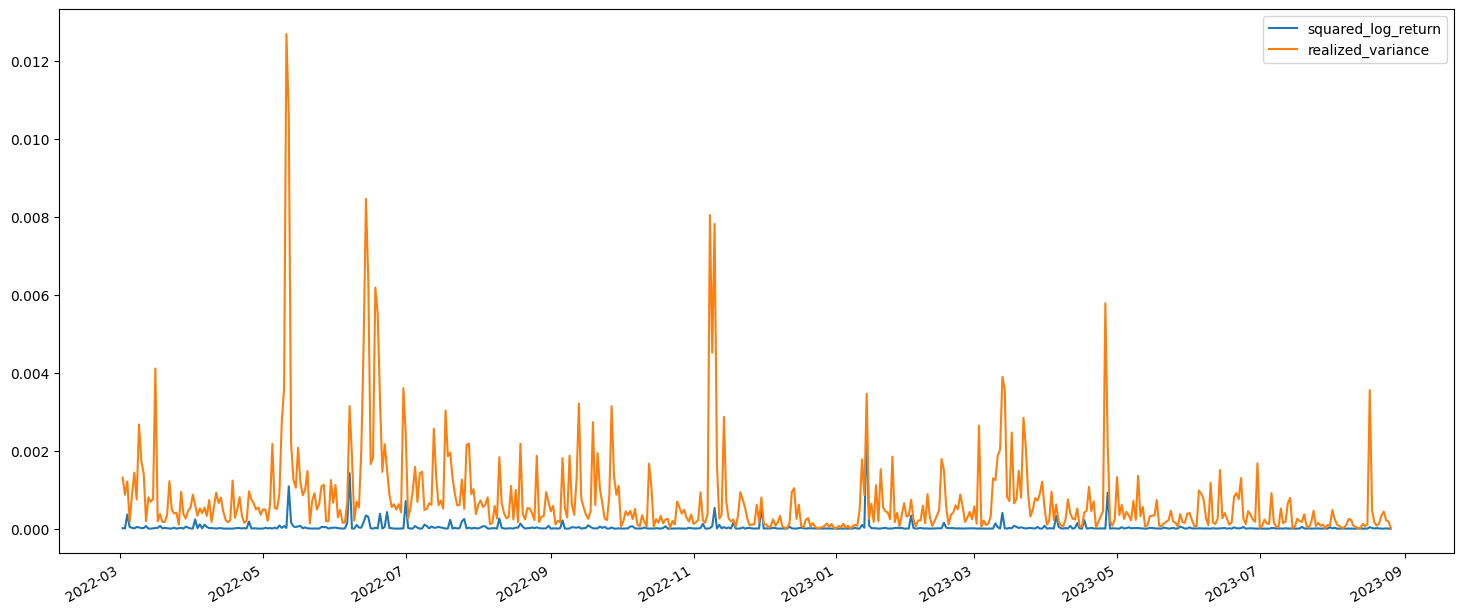

In [142]:
ax1 = df.loc[:, ['squared_log_return', 'realized_variance']].plot(figsize = (18,8))
ax1.xaxis.label.set_visible(False)

<Axes: xlabel='date'>

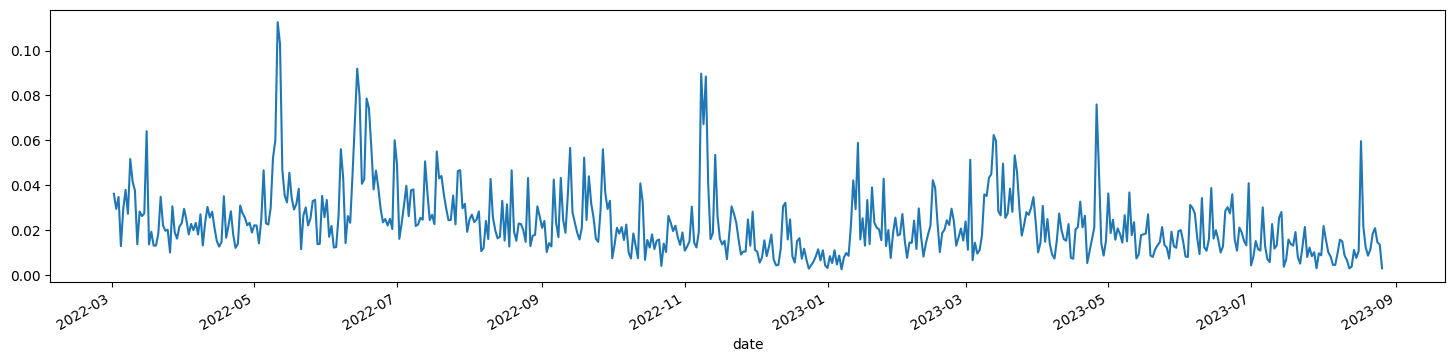

In [143]:
df['realized_volatility'].plot(figsize = (18,4))

(<Axes: title={'center': 'Autocorrelation'}>,
 <Axes: title={'center': 'Partial Autocorrelation'}>)

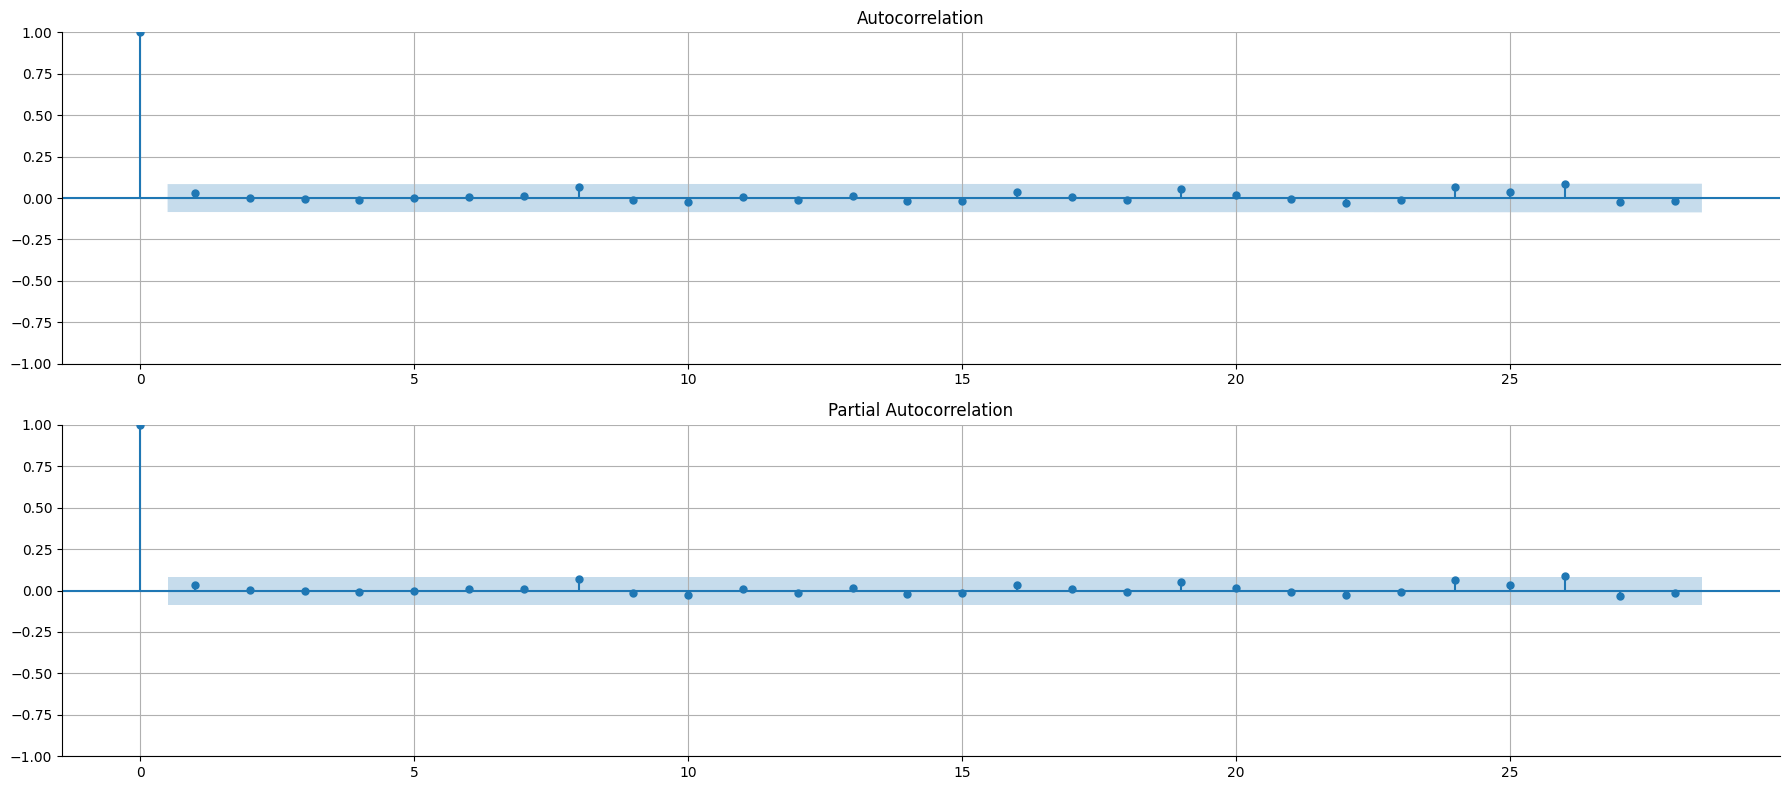

In [144]:
pacfplot(df['squared_log_return'])
pacfplot(df['realized_volatility'])

## Step 7: ARCH Effect Testing


#### Global Variables


In [145]:
cc = 3
model_p = 1
predict_lag = 30
label = 'log_return'  #'log_return_100x'

training_label = label
training_ts = pd.DataFrame(df[training_label], dtype=float)

training_arch_label = label
training_arch = pd.DataFrame(df[training_arch_label], dtype=float)

training_garch_label = label
training_garch = pd.DataFrame(df[training_garch_label], dtype=float)

training_egarch_label = label
training_egarch = pd.DataFrame(df[training_egarch_label], dtype=float)




<Axes: xlabel='date'>

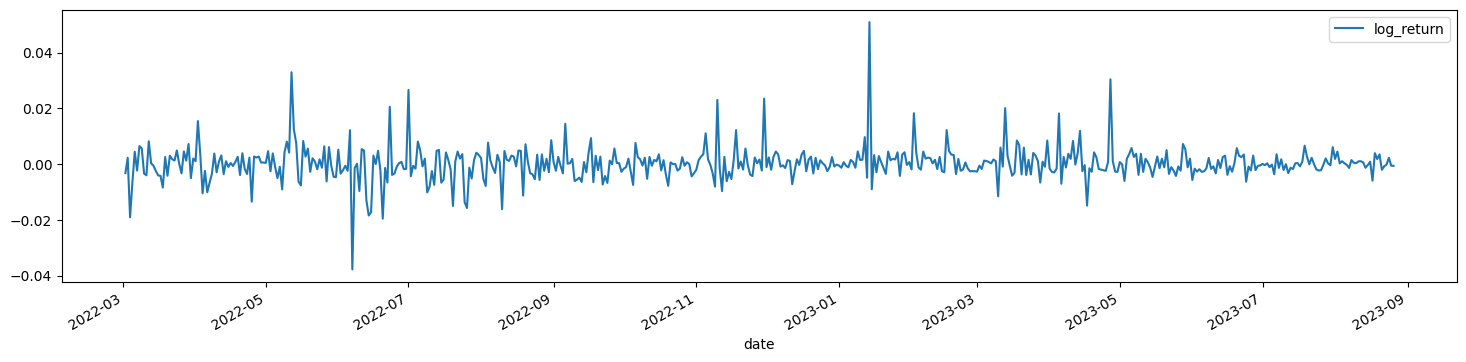

In [146]:
# ARCH Dataset

training_arch.plot(figsize = (18,4))

#### Residuals, Normality, and Variance Tests


In [147]:
t = sm.tsa.stattools.adfuller(training_arch[training_arch_label])  # adf test
print("p-value: %2f  " %t[1])

#Null Hypothesis (H0): The sequence is non-stationary.
#Alternative Hypothesis (H1): The sequence is stationary.
#If p-value is less than the significance level, reject H0, and conclude that the sequence is stationary.
#Next, we'll establish the AR(p) model, but first determine the order.

p-value: 0.000000  


(<Axes: title={'center': 'Autocorrelation'}>,
 <Axes: title={'center': 'Partial Autocorrelation'}>)

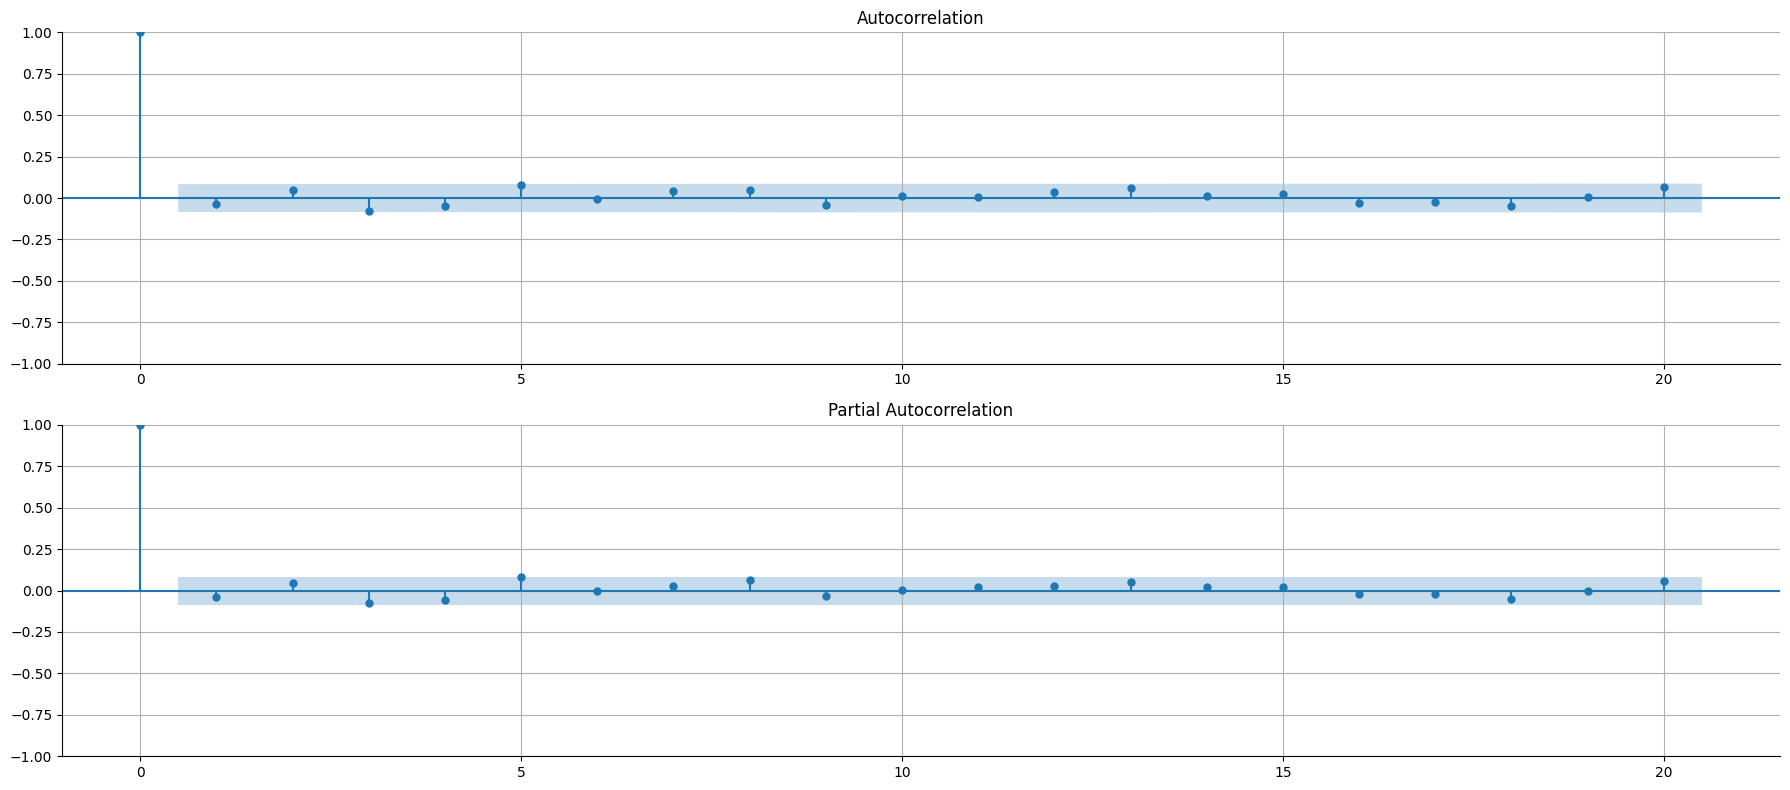

In [148]:
#Null Hypothesis (H0): The sequence is non-stationary.
#Alternative Hypothesis (H1): The sequence is stationary.
#If p-value is less than the significance level, reject H0, and conclude that the sequence is stationary.
#Next, we'll establish the AR(p) model, but first determine the order.
pacfplot(training_arch,lags=20)

#### Build ARIMA Mean Model
    

In [149]:
training_arma_model = smt.SARIMAX(endog=training_ts, trend='c', order=(0, 0, 1), 
                             seasonal_order=(0, 0, 0, 0)#, 
#                              simple_differencing=False,
#                              enforce_stationarity=False,
#                              enforce_invertibility=False
                            )
arma_model_results = training_arma_model.fit(disp=False)
arma_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log_return   No. Observations:                  540
Model:               SARIMAX(0, 0, 1)   Log Likelihood                1985.329
Date:                Mon, 28 Aug 2023   AIC                          -3964.658
Time:                        16:42:41   BIC                          -3951.783
Sample:                             0   HQIC                         -3959.623
                                - 540                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      0.779      0.436      -0.000       0.001
ma.L1         -0.0301      0.036     -0.836      0.403      -0.101       0.041
sigma2      3.747e-05    8.6e-07     43.586      0.000    3.58e-05    3.92e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              5048.25
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [150]:
training_arma_fitvalue = pd.DataFrame(arma_model_results.fittedvalues,dtype=float)  # test for ARCH Effect and create graphs of residuals and squared residuals
at = pd.merge(training_ts, training_arma_fitvalue, on='date')
at.columns = ['log_return', 'model_fit']
at['res'] = at['log_return'] - at['model_fit']
at['res2'] = np.square(at['res'])
at.head()

,log_return,model_fit,res,res2
date,,,,
2022-03-02 00:00:00+00:00,-0.003242,0.000210,-0.003453,0.000012
2022-03-03 00:00:00+00:00,0.002262,0.000314,0.001947,0.000004
2022-03-04 00:00:00+00:00,-0.019063,0.000152,-0.019215,0.000369
2022-03-05 00:00:00+00:00,-0.006563,0.000789,-0.007352,0.000054
2022-03-06 00:00:00+00:00,0.004451,0.000432,0.004019,0.000016


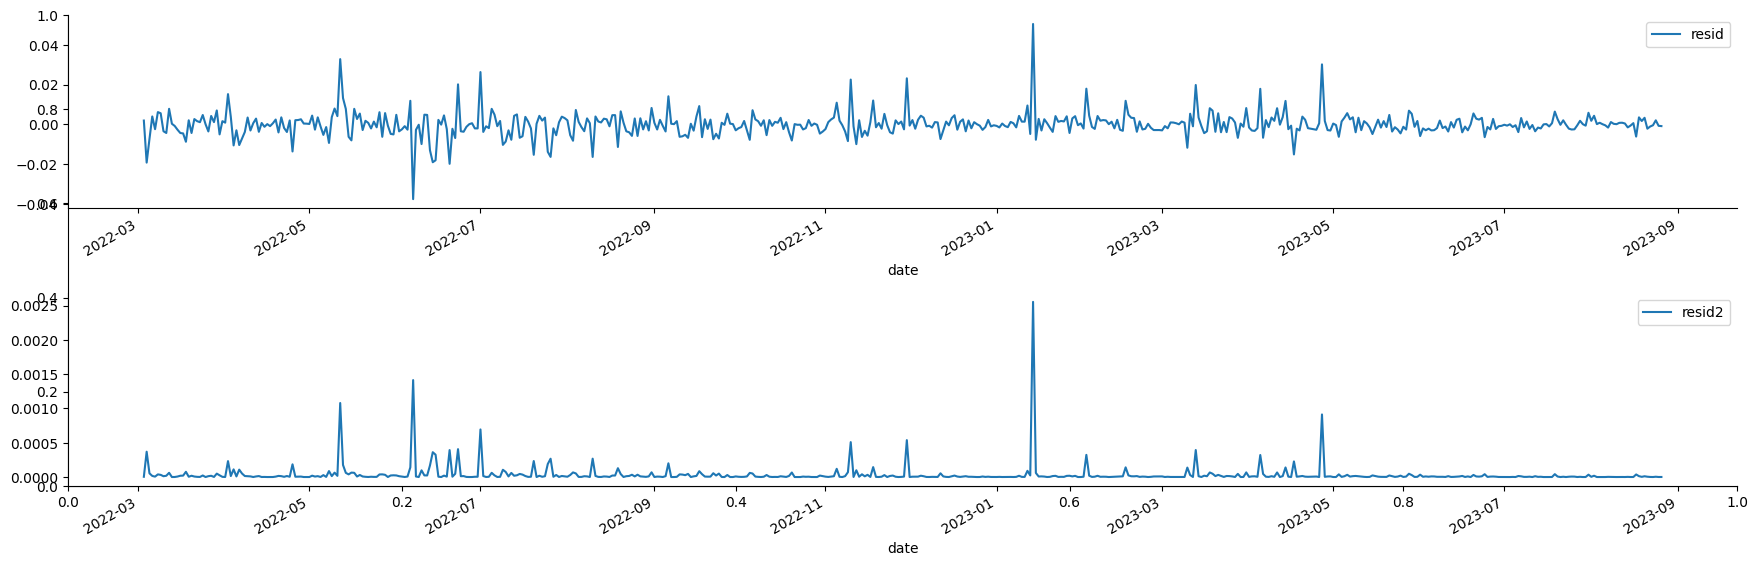

In [151]:
fig, ax = plt.subplots(figsize=(18, 6))
ax1 = fig.add_subplot(2,1,1)
at['res'][1:].plot(ax=ax1,label='resid')
plt.legend(loc='best')

ax2 = fig.add_subplot(2,1,2)
at['res2'][1:].plot(ax=ax2,label='resid2')

plt.legend(loc='best')
plt.tight_layout()
sns.despine()

In [152]:
# Conduct Ljung-Box test on {a2t} sequence:
# Null Hypothesis (H0): The sequence has no autocorrelation.
# Alternative Hypothesis (H1): The sequence has autocorrelation.
acf, q, p = sm.tsa.acf(at['res2'], nlags=20, qstat=True)  ## Calculate autocorrelation coefficients and p-values
out = np.c_[range(1, 21), acf[1:], q, p]
output = pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output  # p<0.05 suggests that the residual sequence has autocorrelation, indicating the presence of the ARCH effect and conforming to the assumption of heteroskedasticity.

,AC,Q,P-value
lag,,,
1.0,0.031187,0.528128,0.467395
2.0,0.001556,0.529446,0.767419
3.0,-0.002126,0.531909,0.911827
4.0,-0.010299,0.589827,0.964187
5.0,-0.000892,0.590263,0.988445
6.0,0.010403,0.649580,0.995515
7.0,0.015897,0.788349,0.997561
8.0,0.071389,3.592124,0.891924
9.0,-0.009987,3.647105,0.933068


#### Determining ARCH Model Order


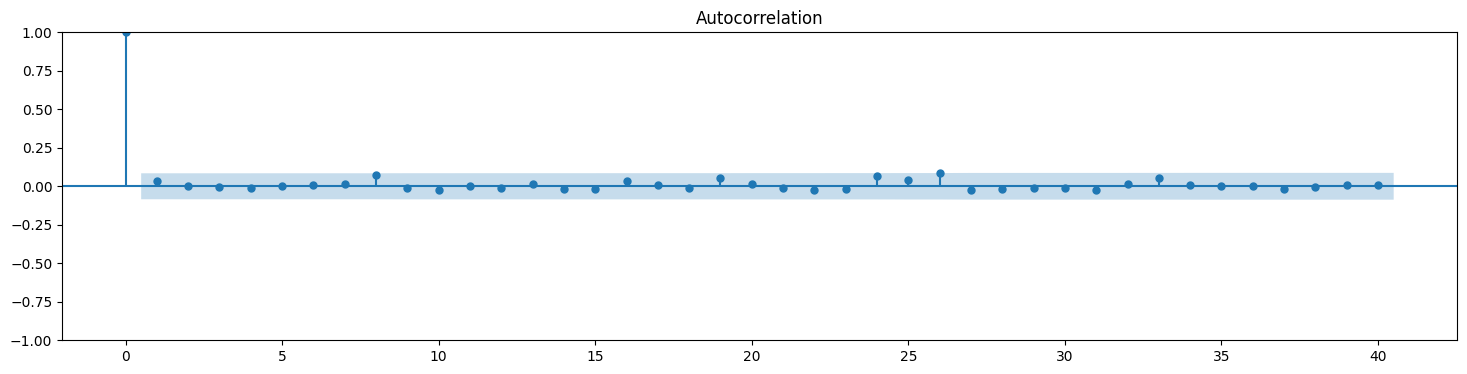

In [153]:
# Using partial autocorrelation function (pACF) of the sequence {a2t}:
figure = plt.figure(figsize=(18,4))
ax1 = figure.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(at['res2'],lags = 40, ax=ax1) # P = 3

## Building the ARCH Model


In [154]:
trained_ARCH = arch_model(training_arch, mean='AR', vol='ARCH', 
                          lags=5, p=1, dist='ged')
res_ARCH = trained_ARCH.fit(disp=False, options={'ftol': 1e-01})
res_ARCH.summary()  # Obtain the model


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - ARCH Model Results                                  
==========================================================================================
Dep. Variable:                         log_return   R-squared:                       0.020
Mean Model:                                    AR   Adj. R-squared:                  0.010
Vol Model:                                   ARCH   Log-Likelihood:                2045.27
Distribution:      Generalized Error Distribution   AIC:                          -4072.54
Method:                        Maximum Likelihood   BIC:                          -4034.00
                                                    No. Observations:                  535
Date:                            Mon, Aug 28 2023   Df Residuals:                      529
Time:                                    16:43:19   Df Model:                            6
                                   Mean Model                                   
================================================================================
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const         1.8381e-04  1.958e-04      0.939      0.348 [-1.999e-04,5.675e-04]
log_return[1]    -0.0352  4.989e-02     -0.705      0.481    [ -0.133,6.261e-02]
log_return[2]     0.0540  2.274e-02      2.372  1.767e-02  [9.379e-03,9.852e-02]
log_return[3]    -0.0802  3.459e-02     -2.318  2.043e-02   [ -0.148,-1.239e-02]
log_return[4]    -0.0535  6.426e-02     -0.833      0.405    [ -0.179,7.241e-02]
log_return[5]     0.0822  5.006e-02      1.642      0.101   [-1.593e-02,  0.180]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.9065e-05  1.935e-06     15.018  5.581e-51 [2.527e-05,3.286e-05]
alpha[1]       0.2000      0.310      0.646      0.518     [ -0.407,  0.807]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.5000      0.392      3.823  1.319e-04 [  0.731,  2.269]
========================================================================

Covariance estimator: robust
"""

In [155]:
res_ARCH.params

Const            0.000184
log_return[1]   -0.035175
log_return[2]    0.053952
log_return[3]   -0.080183
log_return[4]   -0.053531
log_return[5]    0.082193
omega            0.000029
alpha[1]         0.200000
nu               1.500000
Name: params, dtype: float64

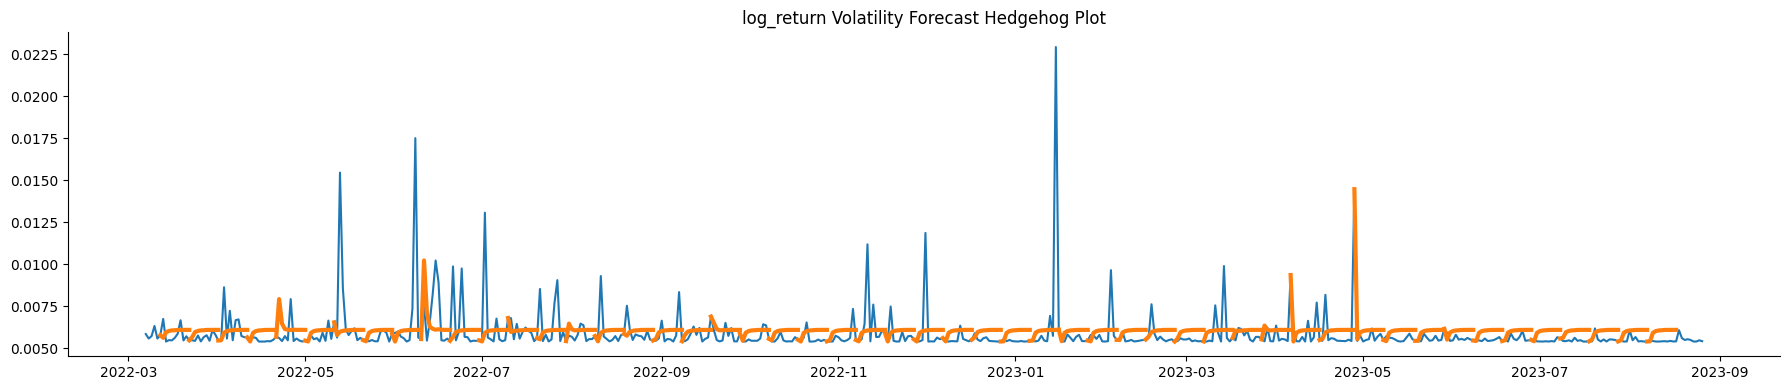

In [156]:
fig = res_ARCH.hedgehog_plot(plot_type='volatility')
fig.set_size_inches(18, 4)
plt.tight_layout()
sns.despine()

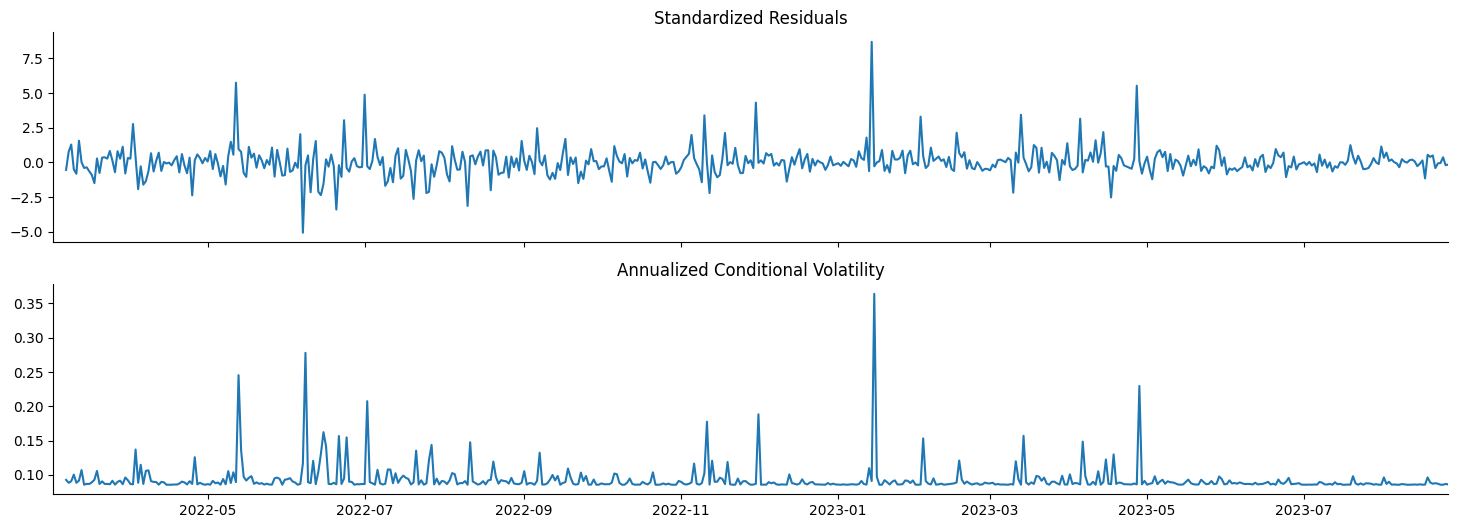

In [157]:
fig = res_ARCH.plot(annualize='D')# standardized residual
fig.set_size_inches(18, 6)# conditional volatility
sns.despine()

#### ARCH Forecasting

ARCH Model:
            $$a_t = \sigma_t \epsilon_t \\
              \sigma^2_t = \alpha_0 + \alpha_1 a^2_{t-1} + \cdots + \alpha_m a^2_{t-m}$$
Where $\{ \epsilon_t \}$ is a sequence of independently and identically distributed random variables with mean 0 and variance 1, and $\alpha_0 > 0, \alpha_1, \cdots, \alpha_m \geq 0$.

Mean Absolute Error (MAE): 0.02
Mean Absolute Percentage Error (MAPE): 99.7
Root Mean Square Error (RMSE): 0.0238


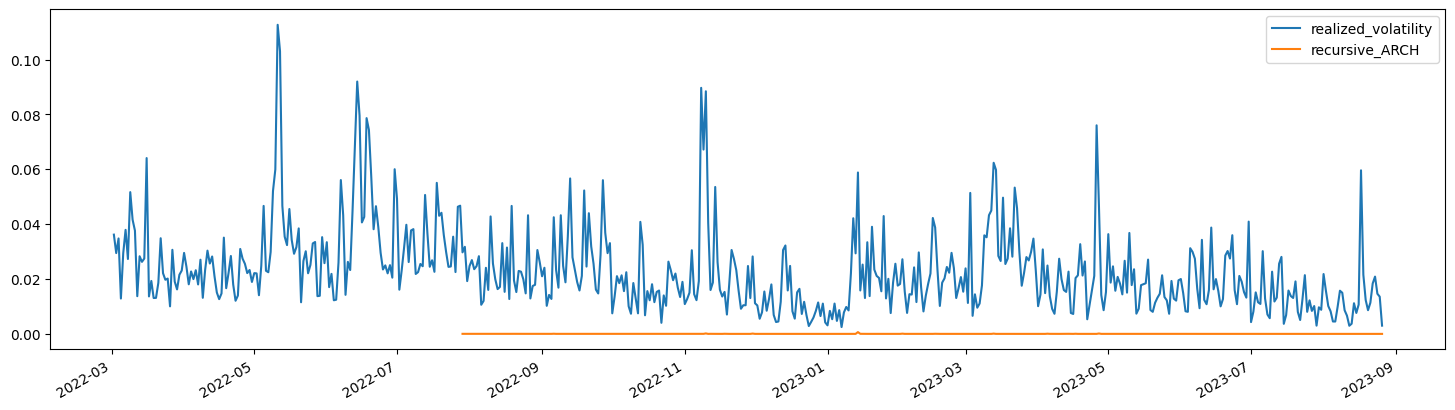

In [158]:
def recursive_forecast(pd_dataframe):     
    window = 150
    model = 'ARCH'
    index = df[1:].index
    end_loc = np.where(index >= df.index[window])[0].min()
    forecasts = {}
    for i in range(len(df[1:]) - window + 2):
        mod = arch_model(pd_dataframe['log_return'][1:], mean='AR', vol=model, dist='ged', p=1)
        res = mod.fit(last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
        temp = res.forecast().variance
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast

    forecasts = pd.DataFrame(forecasts).T
    pd_dataframe['recursive_{}'.format(model)] = forecasts['h.1']
    evaluate(pd_dataframe, 'realized_volatility', 'recursive_{}'.format(model))

recursive_forecast(df)

## Building GARCH Model


In [159]:
am_GARCH = arch_model(training_garch, mean='AR', vol='GARCH',
                      p=1, q=1, lags=4, dist='ged')
res_GARCH = am_GARCH.fit(disp=False, options={'ftol': 1e-01})
res_GARCH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - GARCH Model Results                                 
==========================================================================================
Dep. Variable:                         log_return   R-squared:                       0.012
Mean Model:                                    AR   Adj. R-squared:                  0.005
Vol Model:                                  GARCH   Log-Likelihood:                2050.55
Distribution:      Generalized Error Distribution   AIC:                          -4083.11
Method:                        Maximum Likelihood   BIC:                          -4044.55
                                                    No. Observations:                  536
Date:                            Mon, Aug 28 2023   Df Residuals:                      531
Time:                                    16:43:58   Df Model:                            5
                                   Mean Model                                   
================================================================================
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const         2.1810e-04  2.073e-04      1.052      0.293 [-1.883e-04,6.244e-04]
log_return[1]    -0.0419  4.968e-02     -0.843      0.399    [ -0.139,5.550e-02]
log_return[2]     0.0430  4.055e-02      1.062      0.288   [-3.643e-02,  0.123]
log_return[3]    -0.0760  3.821e-02     -1.990  4.659e-02   [ -0.151,-1.147e-03]
log_return[4]    -0.0573  9.507e-02     -0.603      0.547      [ -0.244,  0.129]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.8279e-05  1.600e-10  1.142e+05      0.000 [1.828e-05,1.828e-05]
alpha[1]       0.2000      0.633      0.316      0.752     [ -1.040,  1.440]
beta[1]        0.3000      0.313      0.958      0.338     [ -0.313,  0.913]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.5000      0.352      4.267  1.982e-05 [  0.811,  2.189]
========================================================================

Covariance estimator: robust
"""

In [160]:
res_GARCH.params  # model

Const            0.000218
log_return[1]   -0.041876
log_return[2]    0.043045
log_return[3]   -0.076034
log_return[4]   -0.057286
omega            0.000018
alpha[1]         0.200000
beta[1]          0.300000
nu               1.500000
Name: params, dtype: float64

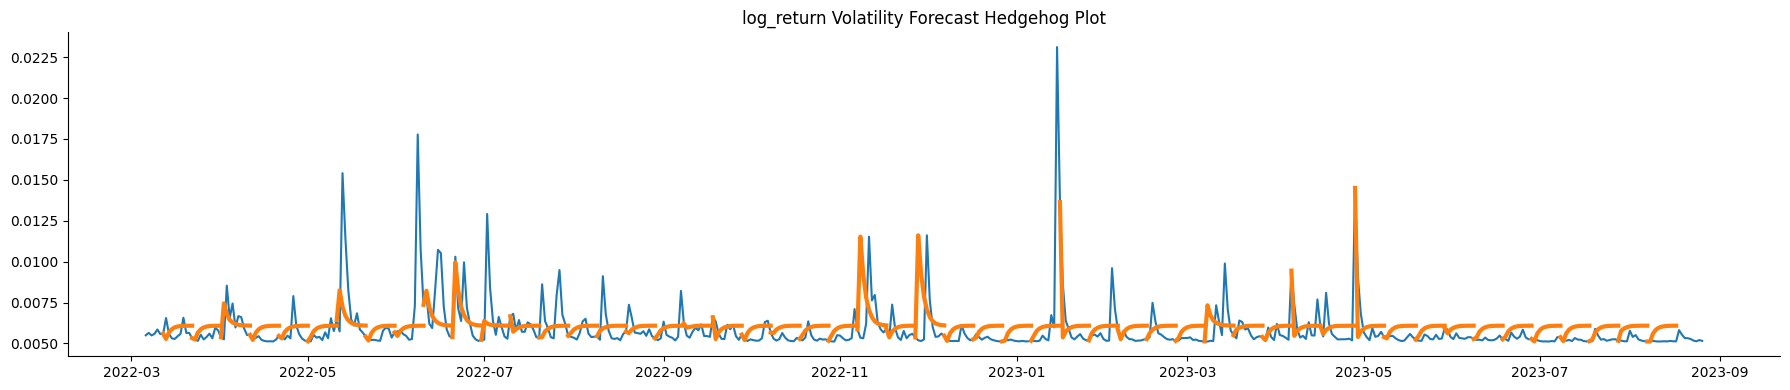

In [161]:
fig = res_GARCH.hedgehog_plot(plot_type='volatility')
fig.set_size_inches(18, 4)
plt.tight_layout()
sns.despine()

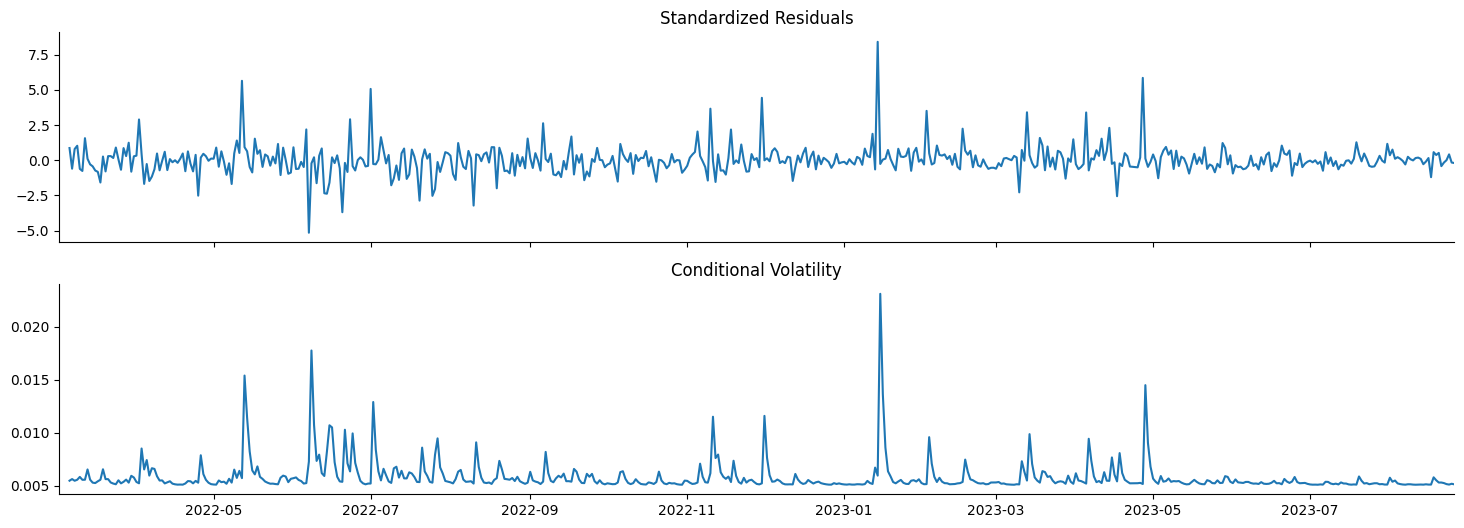

In [162]:
fig = res_GARCH.plot()# standardized residual
fig.set_size_inches(18, 6)# conditional volatility
sns.despine()

#### GARCH Forecasting


Mean Absolute Error (MAE): 0.02
Mean Absolute Percentage Error (MAPE): 99.7
Root Mean Square Error (RMSE): 0.0238


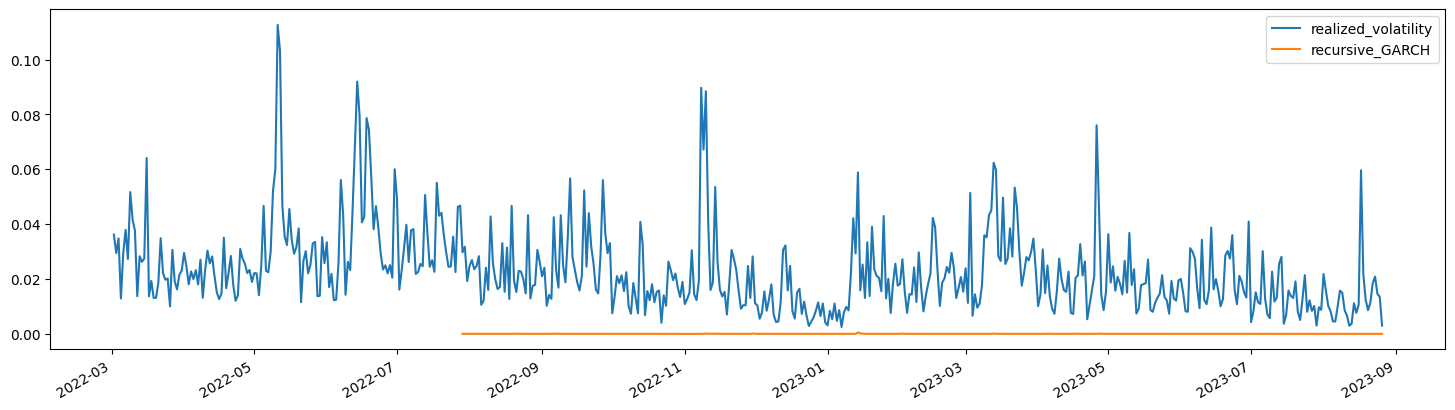

In [163]:
def recursive_forecast(pd_dataframe):     
    window = 150
    model = 'GARCH'
    index = df[1:].index
    end_loc = np.where(index >= df.index[window])[0].min()
    forecasts = {}
    for i in range(len(df[1:]) - window + 2):
        mod = arch_model(pd_dataframe['log_return'][1:], mean='AR', vol=model, dist='ged',p=1, q=1)
        res = mod.fit(last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
        temp = res.forecast().variance
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast

    forecasts = pd.DataFrame(forecasts).T
    pd_dataframe['recursive_{}'.format(model)] = forecasts['h.1']
    evaluate(pd_dataframe, 'realized_volatility', 'recursive_{}'.format(model))

recursive_forecast(df)

## Step 10: Building the EGARCH Model


In [164]:
# am_EGARCH = arch_model(training_egarch, mean='AR',vol='EGARCH',
#                        p=model_lags,lags=model_lags, o=1,q=1, dist='ged',power = 2)
am_EGARCH = arch_model(training_egarch, mean='AR', vol='EGARCH', 
                       p=1, lags=4, o=1, q=1, dist='ged')
res_EGARCH = am_EGARCH.fit(disp=False, options={'ftol': 1e-01})
res_EGARCH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                AR - EGARCH Model Results                                 
==========================================================================================
Dep. Variable:                         log_return   R-squared:                       0.012
Mean Model:                                    AR   Adj. R-squared:                  0.005
Vol Model:                                 EGARCH   Log-Likelihood:                2053.94
Distribution:      Generalized Error Distribution   AIC:                          -4087.87
Method:                        Maximum Likelihood   BIC:                          -4045.03
                                                    No. Observations:                  536
Date:                            Mon, Aug 28 2023   Df Residuals:                      531
Time:                                    16:44:17   Df Model:                            5
                                    Mean Model                                   
=================================================================================
                    coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------------
Const         1.6961e-04  1.332e-04      1.274      0.203  [-9.141e-05,4.306e-04]
log_return[1]    -0.0419  2.708e-02     -1.546      0.122  [-9.495e-02,1.120e-02]
log_return[2]     0.0430  4.900e-03      8.784  1.576e-18   [3.344e-02,5.265e-02]
log_return[3]    -0.0760  2.757e-02     -2.757  5.827e-03    [ -0.130,-2.199e-02]
log_return[4]    -0.0573  1.056e-02     -5.425  5.808e-08 [-7.798e-02,-3.659e-02]
                              Volatility Model                              
============================================================================
                  coef    std err          t      P>|t|     95.0% Conf. Int.
----------------------------------------------------------------------------
omega          -3.0650      1.174     -2.611  9.016e-03    [ -5.365, -0.765]
alpha[1]        0.2000      0.112      1.779  7.526e-02 [-2.036e-02,  0.420]
gamma[1]   -6.2396e-07  8.773e-02 -7.112e-06      1.000    [ -0.172,  0.172]
beta[1]         0.7000      0.114      6.162  7.177e-10    [  0.477,  0.923]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.5000      0.352      4.266  1.992e-05 [  0.811,  2.189]
========================================================================

Covariance estimator: robust
"""

In [165]:
temp = res_EGARCH.forecast().variance
# fcast = temp.iloc[i + end_loc - 1]
# forecasts[fcast.name] = fcast
# temp
np.mean(temp['h.1'])

2.5263239602237663e-05

In [166]:
res_EGARCH.params

Const            1.696059e-04
log_return[1]   -4.187620e-02
log_return[2]    4.304468e-02
log_return[3]   -7.603338e-02
log_return[4]   -5.728669e-02
omega           -3.064989e+00
alpha[1]         2.000014e-01
gamma[1]        -6.239610e-07
beta[1]          7.000000e-01
nu               1.500000e+00
Name: params, dtype: float64

In [108]:
fig = res_EGARCH.hedgehog_plot(plot_type='volatility')
fig.set_size_inches(18, 4)
plt.tight_layout()
sns.despine()

KeyboardInterrupt: 

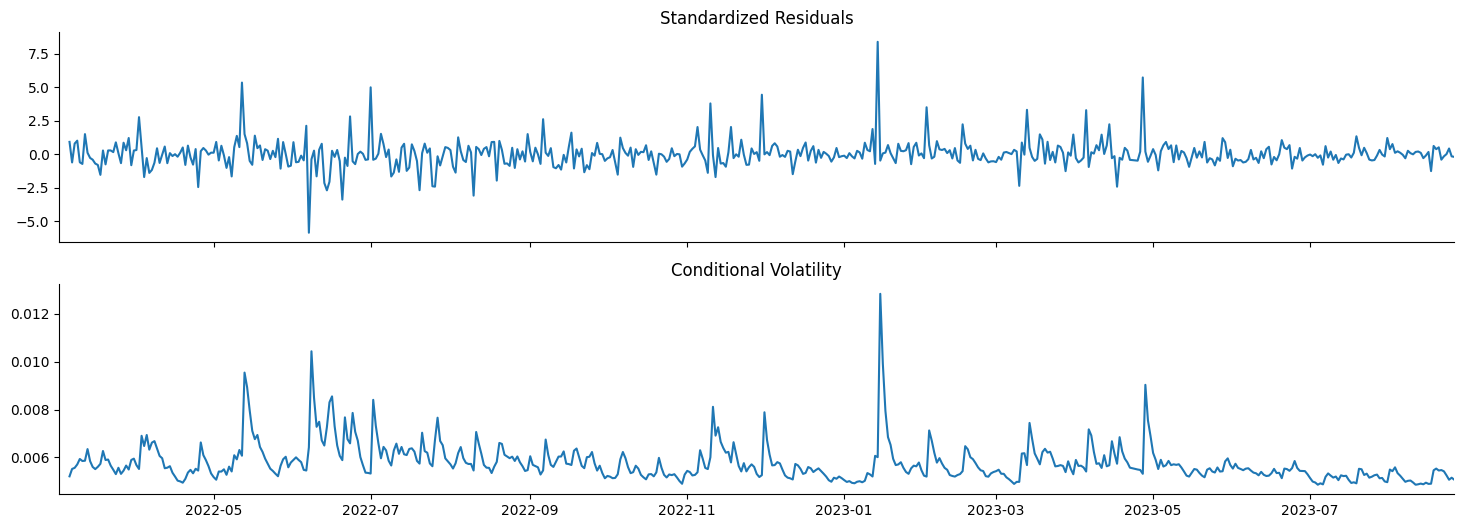

In [167]:
fig = res_EGARCH.plot()# standardized residual
fig.set_size_inches(18, 6)# conditional volatility
sns.despine()

#### EGARCH Forecasting


Mean Absolute Error (MAE): 0.02
Mean Absolute Percentage Error (MAPE): 99.7
Root Mean Square Error (RMSE): 0.0238


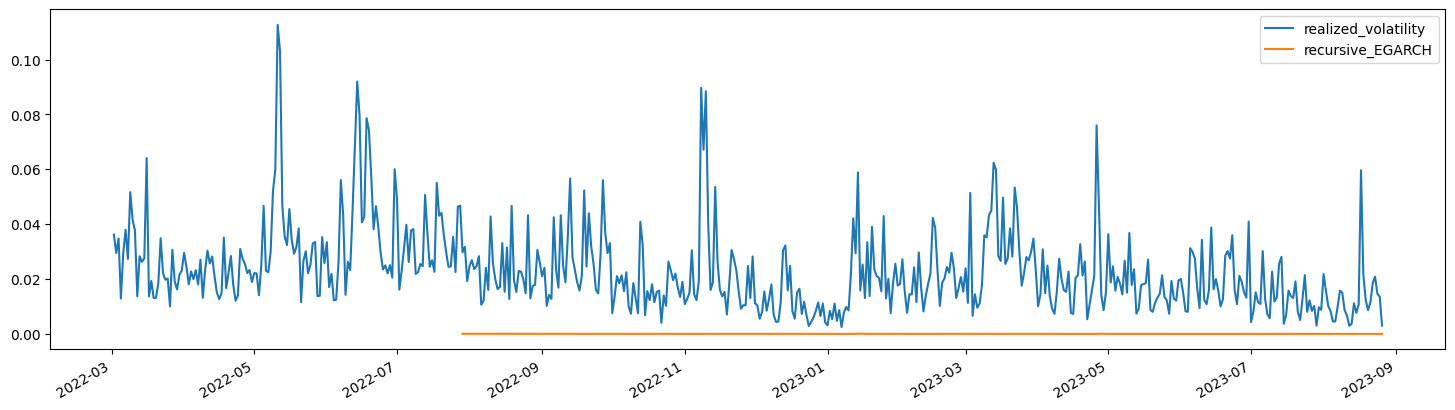

In [168]:
def recursive_forecast(pd_dataframe):     
    window = 150
    model = 'EGARCH'
    index = df[1:].index
    end_loc = np.where(index >= df.index[window])[0].min()
    forecasts = {}
    for i in range(len(df[1:]) - window + 2):
        mod = arch_model(pd_dataframe['log_return'][1:], mean='AR', vol=model, 
                         lags=20, p=2, o=0, q=1, dist='ged')
        res = mod.fit(last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
        temp = res.forecast().variance
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast

    forecasts = pd.DataFrame(forecasts).T
    pd_dataframe['recursive_{}'.format(model)] = forecasts['h.1']
    evaluate(pd_dataframe, 'realized_volatility', 'recursive_{}'.format(model))
    pd_dataframe['recursive_{}'.format(model)]

recursive_forecast(df)

## Step 11: Comparing Forecasting Model Results


In [ ]:
df[99:]

,close,log_price,return,log_return,squared_log_return,return_100x,log_return_100x,realized_variance_1_hour,realized_volatility_1_hour,recursive_ARCH,recursive_GARCH,recursive_EGARCH
date,,,,,,,,,,,,
2020-03-05 07:00:00+08:00,8750.74,9.076894,0.000085,0.000768,5.901774e-07,0.008464,0.076823,0.000017,0.004148,0.000016,0.000017,1.510935e+08
2020-03-05 08:00:00+08:00,8857.35,9.089003,0.001334,0.012109,1.466365e-04,0.133409,1.210935,0.000046,0.006763,0.000031,0.000019,9.378154e+07
2020-03-05 09:00:00+08:00,8871.01,9.090544,0.000170,0.001541,2.374786e-06,0.016955,0.154103,0.000036,0.006019,0.000017,0.000019,3.438122e+07
2020-03-05 10:00:00+08:00,8918.87,9.095925,0.000592,0.005381,2.895086e-05,0.059189,0.538060,0.000077,0.008751,0.000019,0.000019,3.211992e+07
2020-03-05 11:00:00+08:00,8870.97,9.090539,-0.000592,-0.005385,2.899940e-05,-0.059204,-0.538511,0.000035,0.005901,0.000020,0.000019,3.348868e+07
2020-03-05 12:00:00+08:00,8893.42,9.093067,0.000278,0.002528,6.388407e-06,0.027804,0.252753,0.000021,0.004556,0.000017,0.000019,9.707827e-02
2020-03-05 13:00:00+08:00,8923.55,9.096449,0.000372,0.003382,1.143909e-05,0.037195,0.338217,0.000015,0.003867,0.000018,0.000019,3.767136e+07
2020-03-05 14:00:00+08:00,8922.13,9.096290,-0.000017,-0.000159,2.532623e-08,-0.001749,-0.015914,0.000021,0.004548,0.000017,0.000018,4.861538e+07
2020-03-05 15:00:00+08:00,8897.93,9.093574,-0.000299,-0.002716,7.376884e-06,-0.029859,-0.271604,0.000014,0.003795,0.000018,0.000018,6.243177e+07


In [114]:
compare_ARCH_X = pd.DataFrame()
compare_ARCH_X['original']=df['realized_volatility']

compare_ARCH_X['arch']=df['recursive_ARCH']
compare_ARCH_X['arch_diff']=compare_ARCH_X['original']-np.abs(compare_ARCH_X['arch'])

compare_ARCH_X['garch']=df['recursive_GARCH']
compare_ARCH_X['garch_diff']=compare_ARCH_X['original']-np.abs(compare_ARCH_X['garch'])

compare_ARCH_X['egarch']=df['recursive_EGARCH']
compare_ARCH_X['egarch_diff']=compare_ARCH_X['original']-np.abs(compare_ARCH_X['egarch'])
compare_ARCH_X = compare_ARCH_X[280:]
compare_ARCH_X.head(10)

,original,arch,arch_diff,garch,garch_diff,egarch,egarch_diff
date,,,,,,,
2019-01-12,0.112298,0.001096,0.111201,0.001333,0.110964,0.001153,0.111144
2019-01-13,0.106445,0.001186,0.105260,0.001307,0.105138,0.001142,0.105303
2019-01-14,0.114780,0.001291,0.113489,0.001325,0.113455,0.001193,0.113586
2019-01-15,0.116870,0.001139,0.115731,0.001272,0.115597,0.001201,0.115668
2019-01-16,0.117304,0.001104,0.116200,0.001203,0.116101,0.001135,0.116168
2019-01-17,0.058780,0.001095,0.057685,0.001145,0.057635,0.001079,0.057701
2019-01-18,0.058809,0.001085,0.057725,0.001092,0.057718,0.001040,0.057769
2019-01-19,0.062733,0.001133,0.061600,0.001072,0.061660,0.001037,0.061695
2019-01-20,0.065612,0.001211,0.064401,0.001096,0.064516,0.001072,0.064540


In [115]:
compare_ARCH_X_diff = pd.DataFrame(index=['ARCH','GARCH','EGARCH'], columns=['head 1 step', 'head 10 steps', 'head 100 steps'])
compare_ARCH_X_diff['head 1 step']['ARCH'] = compare_ARCH_X['arch_diff']['2020-03-12 20:00:00+08:00']
compare_ARCH_X_diff['head 10 steps']['ARCH'] = np.mean(compare_ARCH_X['arch_diff'][:10])
compare_ARCH_X_diff['head 100 steps']['ARCH'] = np.mean(compare_ARCH_X['arch_diff'][:100])
compare_ARCH_X_diff['head 1 step']['GARCH'] = compare_ARCH_X['garch_diff']['2020-03-12 20:00:00+08:00']
compare_ARCH_X_diff['head 10 steps']['GARCH'] = np.mean(compare_ARCH_X['garch_diff'][:10])
compare_ARCH_X_diff['head 100 steps']['GARCH'] = np.mean(compare_ARCH_X['garch_diff'][:100])
compare_ARCH_X_diff['head 1 step']['EGARCH'] = compare_ARCH_X['egarch_diff']['2020-03-12 20:00:00+08:00']
compare_ARCH_X_diff['head 10 steps']['EGARCH'] = np.mean(compare_ARCH_X['egarch_diff'][:10])
compare_ARCH_X_diff['head 100 steps']['EGARCH'] = np.abs(np.mean(compare_ARCH_X['egarch_diff'][:100]))
compare_ARCH_X_diff

KeyError: Timestamp('2020-03-12 20:00:00+0800', tz='UTC+08:00')

In [117]:
# Evaluate MSE (Mean Squared Error), where an MSE of 0 implies that the estimator predicts the observed values of the parameter with perfect accuracy, an ideal scenario that's often not achievable.
compare_ARCH_X = pd.DataFrame()
compare_ARCH_X['Model'] = ['ARCH','GARCH','EGARCH']
compare_ARCH_X['RMSE'] = [get_rmse(df['realized_volatility'][150:],df['recursive_ARCH'][150:]),
                          get_rmse(df['realized_volatility'][150:],df['recursive_GARCH'][150:]),
                          get_rmse(df['realized_volatility'][150:],df['recursive_EGARCH'][150:])]
compare_ARCH_X['MAPE'] = [get_mape(df['realized_volatility'][150:],df['recursive_ARCH'][150:]),
                          get_mape(df['realized_volatility'][150:],df['recursive_GARCH'][150:]),
                          get_mape(df['realized_volatility'][150:],df['recursive_EGARCH'][150:])]
compare_ARCH_X['MASE'] = [get_mape(df['realized_volatility'][150:],df['recursive_ARCH'][150:]),
                          get_mape(df['realized_volatility'][150:],df['recursive_GARCH'][150:]),
                          get_mape(df['realized_volatility'][150:],df['recursive_EGARCH'][150:])]

compare_ARCH_X

,Model,RMSE,MAPE,MASE
0,ARCH,0.094261,98.024073,98.024073
1,GARCH,0.094103,98.173841,98.173841
2,EGARCH,0.094354,98.407586,98.407586


In [118]:
delta_arch = compare_ARCH_X['arch'] - compare_ARCH_X['original']
adjR_arch = 1 - delta_arch.var()/compare_ARCH_X['original'].var()

delta_garch = compare_ARCH_X['garch'] - compare_ARCH_X['original']
adjR_garch = 1 - delta_garch.var()/compare_ARCH_X['original'].var()

delta_egarch = compare_ARCH_X['egarch'] - compare_ARCH_X['original']
adjR_egarch = 1 - delta_egarch.var()/compare_ARCH_X['original'].var()

vo_adjR_test=pd.DataFrame(index=['ARCH','GARCH','EGARCH'],columns=['adjR2'])
vo_adjR_test['adjR2']['ARCH']=adjR_arch**2
vo_adjR_test['adjR2']['GARCH']=adjR_garch**2
vo_adjR_test['adjR2']['EGARCH']=adjR_egarch**2
vo_adjR_test

KeyError: 'arch'